In [37]:
### インポート

# 数値・確率計算
import pandas as pd
import numpy as np
import scipy.stats as stats

# PyMC
import pymc as pm
import pytensor.tensor as pt
import arviz as az

# 描画
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import arviz as az
# plt.rcParams['font.family'] = 'Meiryo'

# ワーニング表示の抑制
import warnings
warnings.simplefilter('ignore')

In [3]:
### データの読み込み ◆データファイル5.1 data-attendance-1.txtの構成
# A:バイト好き区分(1:好き), Score:学問の興味の強さ（0~200）, Y:授業の出席率（1年間）

data = pd.read_csv('./input/data-attendance-1.txt')
print('data.shape: ', data.shape)
display(data.head())

data.shape:  (50, 3)


,A,Score,Y
0,0,69,0.286
1,1,145,0.196
2,0,125,0.261
3,1,86,0.109
4,1,158,0.230


# 分析の目的
- ２つの説明変数$A$と$Score$で応答変数$Y$がどれほど予測できるか知りたい
- それぞれの説明変数が出席率にどれほど影響しているかを知りたい

この解析結果を発表する場合、聴衆を納得させるにはどういう図を描いて発表資料を作成するべき？

## データ分布の確認

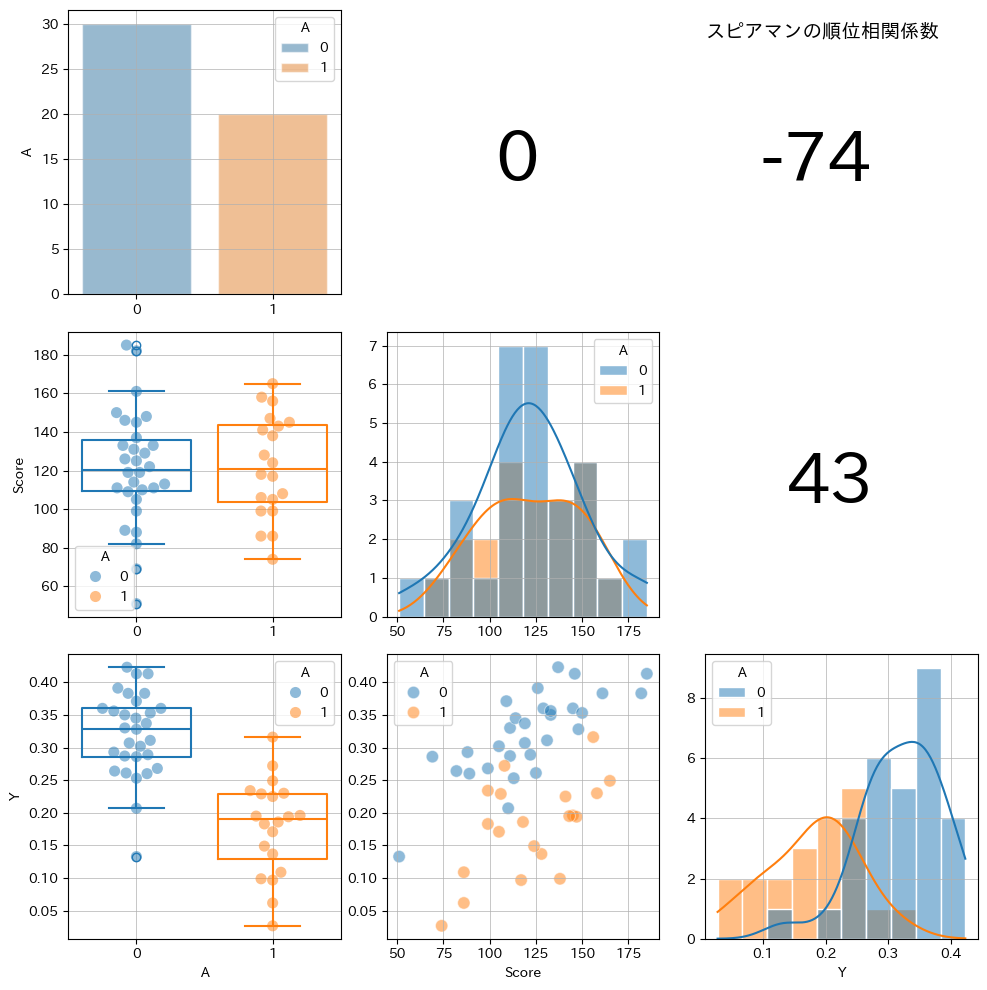

In [4]:
### 散布図行列の描画 ◆図5.1
# 凡例非表示・・・描画関数の引数に legend=None を追加する

## 描画領域の指定
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
ax = ax.ravel() # １次元でaxesを指定したいので

## 番地0,0：ヒストグラムの描画（棒グラフを使用）
bar_A = data.A.value_counts().sort_index()
sns.barplot(ax=ax[0], x=bar_A.index, y=bar_A, hue=bar_A.index, palette='tab10',
            alpha=0.5, ec='white')
ax[0].set(ylabel='A', xlabel=None)
ax[0].grid(lw=0.5)

## 番地0,1：スピアマンの順位相関係数の描画
ax[1].set_axis_off()
corr1, pval1 = stats.spearmanr(data.Score, data.A)
ax[1].text(x=0.4, y=0.4, s=round(corr1 * 100), fontsize=50)

## 番地0,2：スピアマンの順位相関係数の描画
ax[2].set_axis_off()
corr2, pval2 = stats.spearmanr(data.Y, data.A)
ax[2].text(x=0.2, y=0.4, s=round(corr2 * 100), fontsize=50)
ax[2].text(x=0, y=0.9, s='スピアマンの順位相関係数', fontsize=14)

## 番地1,0：箱ひげ図＋スウォームプロットの描画
sns.boxplot(ax=ax[3], x=data.A, y=data.Score, hue=data.A, fill=False,
            legend=None)
sns.swarmplot(ax=ax[3], x=data.A, y=data.Score, hue=data.A, size=8, alpha=0.5)
ax[3].set(xlabel=None)
ax[3].grid(lw=0.5)

## 番地1,1：ヒストグラムの描画
sns.histplot(ax=ax[4], data=data, x='Score', hue='A', bins=10, kde=True, 
             ec='white')
ax[4].set(xlabel=None, ylabel=None)
ax[4].grid(lw=0.5)

## 番地1,2：スピアマンの順位相関係数の描画
ax[5].set_axis_off()
corr3, pval3 = stats.spearmanr(data.Y, data.Score)
ax[5].text(x=0.3, y=0.4, s=round(corr3 * 100), fontsize=50)

## 番地2,0：箱ひげ図＋スウォームプロットの描画
sns.boxplot(ax=ax[6], x=data.A, y=data.Y, hue=data.A, fill=False,
            legend=None)
sns.swarmplot(ax=ax[6], x=data.A, y=data.Y, hue=data.A, size=8, alpha=0.5)
ax[6].grid(lw=0.5)

## 番地2,1：散布図の描画
sns.scatterplot(ax=ax[7], data=data, x='Score', y='Y', hue='A', size='A',
                sizes=(80, 80), alpha=0.5)
ax[7].set(ylabel=None)
ax[7].grid(lw=0.5)

## 番地2,2：ヒストグラムの描画
sns.histplot(ax=ax[8], data=data, x='Y', hue='A', bins=10, kde=True, ec='white')
ax[8].set(ylabel=None)
ax[8].grid(lw=0.5)

plt.tight_layout();

- scoreとYには線形関係がありそう。Aに関わらず。
- A=0/1の違いで、Yは如実に変わる。
→ AとScoreの線型結合でYが決まりそう（仮定・仮説）
  
$$
Y = b_1 + b_2A[n] + b_3Score[n] + \epsilon[n] 
$$

In [10]:
with pm.Model() as model:
    model.add_coord("data", values=data.index, mutable=True)

    Y = pm.ConstantData("Y", value=data["Y"].values, dims="data")
    A = pm.ConstantData("A", value=data["A"].values, dims="data")
    Score = pm.ConstantData("Score", value=data["Score"].values / 200, dims="data")

    ### prior
    b1 = pm.Uniform("b1", lower=-10, upper=10)
    b2 = pm.Uniform("b2", lower=-10, upper=10)
    b3 = pm.Uniform("b3", lower=-10, upper=10)
    sigma = pm.Uniform("sigma", lower=0, upper=10)    # pm.HalfNormalでもいいはず

    ### 線形予測子
    mu = pm.Deterministic("mu", b1+b2*A+b3*Score, dims="data")

    ### 尤度関数
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=Y, dims="data")   ##← dims="data"忘れがち

    ### 計算値
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, dims="data")

# display(model)


    b1 ~ Uniform(-10, 10)
    b2 ~ Uniform(-10, 10)
    b3 ~ Uniform(-10, 10)
 sigma ~ Uniform(0, 10)
y_pred ~ Normal(mu, sigma)
    mu ~ Deterministic(f(b3, b1, b2))
   obs ~ Normal(mu, sigma)

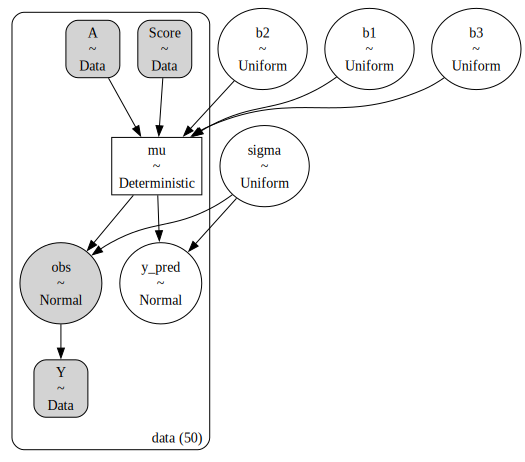

In [11]:
g = pm.model_to_graphviz(model)
display(g)

In [14]:
with model:
    idata = pm.sample(draws=1000, tune=1000, chains=4, target_accept=0.8,
                      nuts_sampler="numpyro", 
                      random_seed=123)

Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]








Running chain 0:  50%|█████     | 1000/2000 [00:01<00:00, 9622.52it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1070.34it/s] 


In [13]:
# sampler 比較 ↑ numpyroがやはり早い
with model:
    idata = pm.sample(draws=1000, tune=1000, chains=4, target_accept=0.8,
                    #   nuts_sampler="numpyro", 
                      random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b1, b2, b3, sigma, y_pred]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [15]:
## rhat > 1.1の確認
# 設定
idata_in = idata 
threshold = 1.01

# 閾値を超えるR_hat個数を表示
print((az.rhat(idata_in) > threshold).sum())

<xarray.Dataset> Size: 48B
Dimensions:  ()
Data variables:
    b1       int64 8B 0
    b2       int64 8B 0
    b3       int64 8B 0
    mu       int64 8B 0
    sigma    int64 8B 0
    y_pred   int64 8B 0


In [16]:
# 事後統計量の確認
var_names = ["b1", "b2", "b3", "sigma", "mu"]
pm.summary(idata, hdi_prob=0.95, var_names=var_names, round_to=3)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b1,0.124,0.033,0.061,0.189,0.001,0.001,1755.863,2560.723,1.003
b2,-0.144,0.015,-0.174,-0.115,0.000,0.000,3127.780,3139.121,1.001
b3,0.324,0.052,0.219,0.423,0.001,0.001,1756.053,2485.247,1.003
sigma,0.052,0.006,0.041,0.062,0.000,0.000,1735.390,2208.690,1.001
mu[0],0.236,0.017,0.202,0.267,0.000,0.000,2006.410,2876.084,1.001
mu[1],0.215,0.013,0.192,0.241,0.000,0.000,2845.252,2875.566,1.003
mu[2],0.326,0.010,0.306,0.345,0.000,0.000,3267.355,3121.033,0.999
mu[3],0.119,0.015,0.090,0.149,0.000,0.000,2446.482,2771.373,1.001
mu[4],0.236,0.015,0.209,0.266,0.000,0.000,2543.556,2659.839,1.002
mu[5],0.339,0.010,0.319,0.359,0.000,0.000,3187.844,3247.009,1.000


In [34]:
# ベイズ信頼区間を含む、事後統計量

# mean, std, 2.5%, 25%, 50%, 75%, 97.5%
def make_stats_df(y: pd.DataFrame, probs_list=[2.5, 25, 50, 75, 97.5]):
    # probs = [2.5, 25, 50, 75, 97.5]
    columns = ["mean", "std"] + [str(s) + "%" for s in probs_list]
    quantiles = pd.DataFrame(np.percentile(y, probs_list, axis=0).T, index=y.columns)
    tmp_df = pd.concat([y.mean(axis=0), y.std(axis=0), quantiles], axis=1)
    tmp_df.columns = columns
    return tmp_df


num_axis1 = 9
y = pd.DataFrame(np.random.randn(100, num_axis1))  # 100行6列のデータ

# 計算例
# パーセンタイルの計算
probs = [2.5, 25, 50, 75]
percentiles0 = np.percentile(y, probs, axis=0)
percentiles1 = np.percentile(y, probs, axis=1)
print(percentiles0)
# print(percentiles1)

tmp_df = make_stats_df(y)
print(f"{tmp_df.shape=}")
assert tmp_df.shape[0] == num_axis1
display(tmp_df)

[[-2.14303793 -2.36287861 -1.80351615 -1.49806036 -1.61147187 -2.01084192
  -1.99459035 -1.96365049 -1.84579873]
 [-0.53404421 -0.69745543 -0.62033264 -0.88552533 -0.64086298 -0.46968759
  -0.61944286 -0.69460587 -0.78289984]
 [-0.01004885  0.04515308  0.16539068 -0.25972076 -0.07573894  0.1593133
   0.13759636 -0.18294405 -0.11766182]
 [ 0.68760539  0.78992244  0.8439785   0.67236546  0.49692282  0.76786908
   0.62131513  0.5817594   0.64755368]]
tmp_df.shape=(9, 7)


,mean,std,2.5%,25%,50%,75%,97.5%
0,-0.012659,0.990870,-2.143038,-0.534044,-0.010049,0.687605,1.746620
1,-0.021857,1.052153,-2.362879,-0.697455,0.045153,0.789922,1.689117
2,0.102256,1.003479,-1.803516,-0.620333,0.165391,0.843979,1.886614
3,-0.074717,0.999294,-1.498060,-0.885525,-0.259721,0.672365,2.026446
4,-0.019079,0.862047,-1.611472,-0.640863,-0.075739,0.496923,1.617588
5,0.150631,0.967261,-2.010842,-0.469688,0.159313,0.767869,2.130997
6,0.014519,1.027916,-1.994590,-0.619443,0.137596,0.621315,1.966203
7,-0.111293,0.909436,-1.963650,-0.694606,-0.182944,0.581759,1.578468
8,-0.089677,1.032447,-1.845799,-0.782900,-0.117662,0.647554,1.691405


In [40]:
vars = ["b1", "b2", "b3", "mu", "sigma"]
param_samples = idata.posterior[vars].to_dataframe().reset_index(drop=True)
display(param_samples.head())
display(make_stats_df(param_samples).round(2))

,b1,b2,b3,mu,sigma
0,0.11558,-0.148222,0.353693,0.237605,0.051449
1,0.11558,-0.148222,0.353693,0.223786,0.051449
2,0.11558,-0.148222,0.353693,0.336639,0.051449
3,0.11558,-0.148222,0.353693,0.119447,0.051449
4,0.11558,-0.148222,0.353693,0.246776,0.051449


,mean,std,2.5%,25%,50%,75%,97.5%
b1,0.12,0.03,0.06,0.10,0.12,0.15,0.19
b2,-0.14,0.02,-0.17,-0.15,-0.14,-0.13,-0.11
b3,0.32,0.05,0.22,0.29,0.32,0.36,0.42
mu,0.26,0.08,0.11,0.20,0.28,0.33,0.42
sigma,0.05,0.01,0.04,0.05,0.05,0.06,0.06


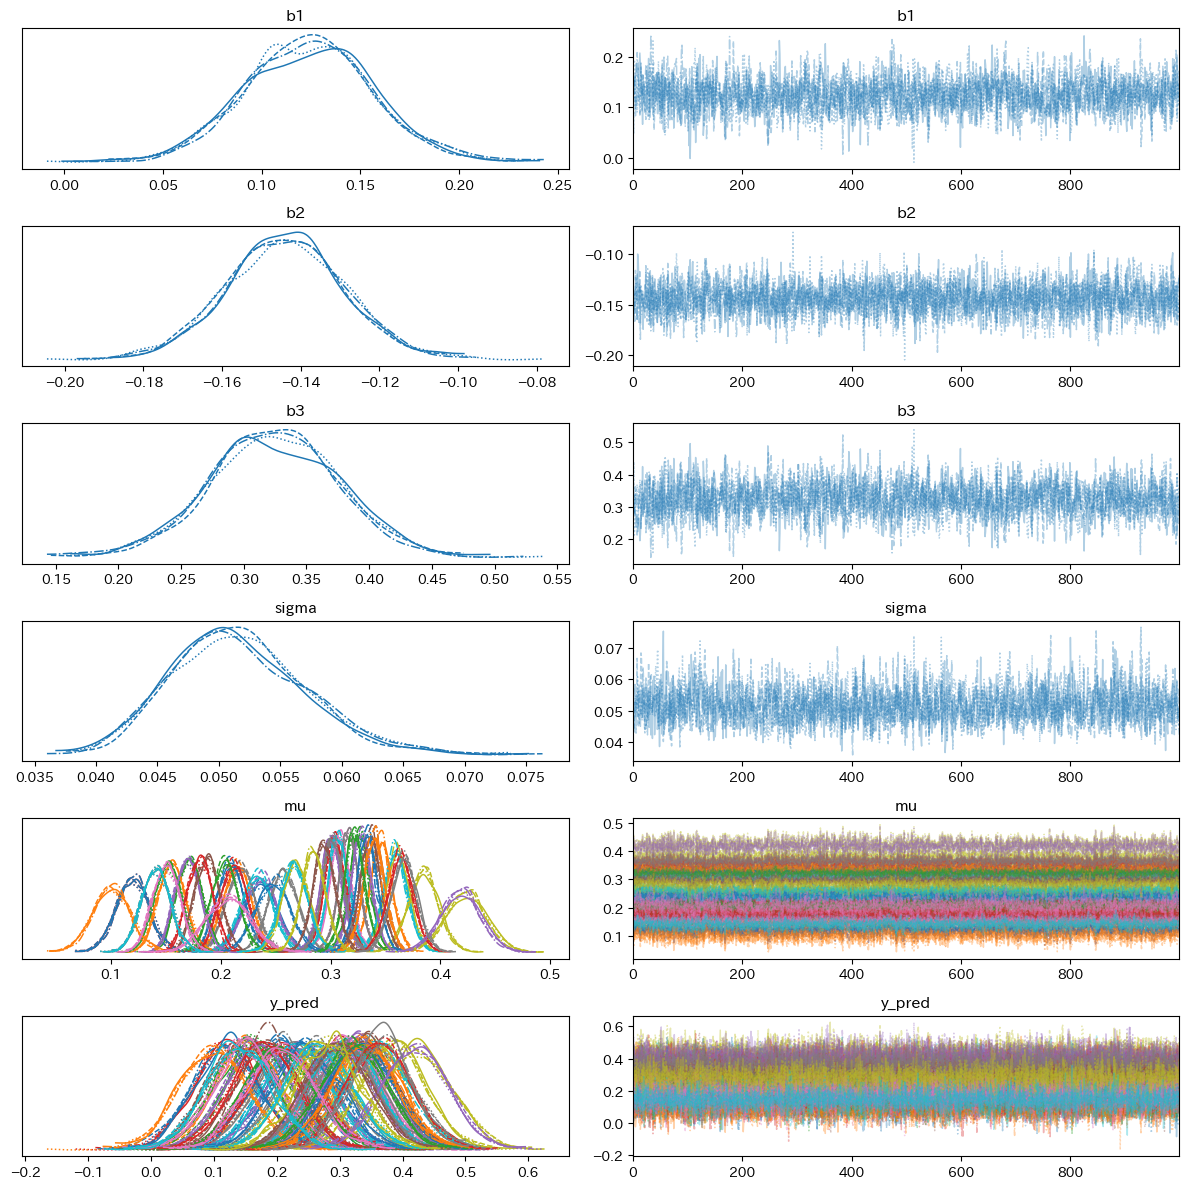

In [41]:
var_names = ["b1", "b2", "b3", "sigma", "mu", "y_pred"]
az.plot_trace(idata, compact=True, var_names=var_names)
plt.tight_layout()

In [49]:
rng = np.random.default_rng(seed=123)

x_scores = np.linspace(50, 200, 1001)
# mcmcサンプリングからb1~sigmaを取り出す
b1_samples = idata.posterior.b1.stack(sample=("chain", "draw")).data
b2_samples = idata.posterior.b2.stack(sample=("chain", "draw")).data
b3_samples = idata.posterior.b3.stack(sample=("chain", "draw")).data
sigma_samples = idata.posterior.sigma.stack(sample=("chain", "draw")).data

# アルバイト０とアルバイト１ごとに平均値muを計算（回帰式）
mu_A0 = np.array([b1_samples + b2_samples * 0 + b3_samples * x_score / 200 for x_score in x_scores])
mu_A1 = np.array([b1_samples + b2_samples * 1 + b3_samples * x_score / 200 for x_score in x_scores])

# アルバイト０とアルバイt１ごとに正規分布乱数でYの予測分布を計算
y_pred_A0 = rng.normal(loc=mu_A0, scale=sigma_samples)
y_pred_A1 = rng.normal(loc=mu_A1, scale=sigma_samples)

# 予測分布Yの80%のCI
y_pred_A0_80ci = np.quantile(y_pred_A0, q=[0.1, 0.9], axis=1)
y_pred_A1_80ci = np.quantile(y_pred_A1, q=[0.1, 0.9], axis=1)
print(f"{y_pred_A0_80ci.shape=}")
print(f"{y_pred_A1_80ci.shape=}")

y_pred_A0_80ci.shape=(2, 1001)
y_pred_A1_80ci.shape=(2, 1001)


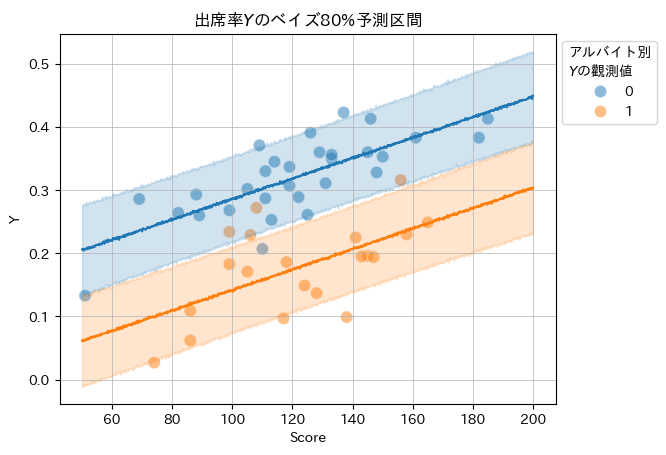

In [48]:
## 描画処理
# 観測値の散布図の描画
sns.scatterplot(data=data, x='Score', y='Y', hue='A', size='A', sizes=(80, 80),
                alpha=0.5)
# アルバイト0のyの予測分布の中央値を描画
plt.plot(x_scores, np.median(y_pred_A0, axis=1), color='tab:blue')
# アルバイト0のyの予測分布の80%CIを描画
plt.fill_between(x_scores, y_pred_A0_80ci[0], y_pred_A0_80ci[1],
                 color='tab:blue', alpha=0.2)
# アルバイト1のyの予測分布の中央値を描画
plt.plot(x_scores, np.median(y_pred_A1, axis=1), color='tab:orange')
# アルバイト1のyの予測分布の80%CIを描画
plt.fill_between(x_scores, y_pred_A1_80ci[0], y_pred_A1_80ci[1],
                 color='tab:orange', alpha=0.2)
# 修飾
plt.title('出席率$Y$のベイズ80%予測区間')
plt.legend(bbox_to_anchor=(1, 1), title='アルバイト別\n$Y$の觀測値')
plt.grid(lw=0.5);